In [5]:
# KAGGLE
# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/gen-model-140/gen_model_140.h5
/kaggle/input/gen-model-120/gen_model_120.h5
/kaggle/input/brain-tumor-mri-dataset/Training/pituitary/Tr-pi_0532.jpg
/kaggle/input/brain-tumor-mri-dataset/Training/pituitary/Tr-pi_0282.jpg
/kaggle/input/brain-tumor-mri-dataset/Training/pituitary/Tr-pi_1401.jpg
/kaggle/input/brain-tumor-mri-dataset/Training/pituitary/Tr-pi_0914.jpg
/kaggle/input/brain-tumor-mri-dataset/Training/pituitary/Tr-pi_0691.jpg
/kaggle/input/brain-tumor-mri-dataset/Training/pituitary/Tr-pi_0972.jpg
/kaggle/input/brain-tumor-mri-dataset/Training/pituitary/Tr-pi_0818.jpg
/kaggle/input/brain-tumor-mri-dataset/Training/pituitary/Tr-pi_0463.jpg
/kaggle/input/brain-tumor-mri-dataset/Training/pituitary/Tr-pi_0930.jpg
/kaggle/input/brain-tumor-mri-dataset/Training/pituitary/Tr-pi_1323.jpg
/kaggle/input/brain-tumor-mri-dataset/Training/pituitary/Tr-pi_1347.jpg
/kaggle/input/brain-tumor-mri-dataset/Training/pituitary/Tr-pi_1354.jpg
/kaggle/input/brain-tumor-mri-dataset/Training

## Importamos paquetes necesarios

In [32]:
# importamos paquetes necesarios
from tensorflow import keras

from numpy import expand_dims
from numpy import zeros
from numpy import ones
from numpy import asarray
from numpy.random import randn
from numpy.random import randint
from tensorflow.keras.datasets.fashion_mnist import load_data
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Reshape
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import Conv2DTranspose
from tensorflow.keras.layers import LeakyReLU
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Embedding
from tensorflow.keras.layers import Concatenate
from tensorflow.keras.layers import Average
from tensorflow.keras.layers import Minimum
from tensorflow.keras.layers import Maximum
from keras.utils.vis_utils import plot_model
from keras.models import load_model
from matplotlib import pyplot
from tqdm import tqdm
import cv2
import numpy as np
import matplotlib.pyplot as plt
import time
from sklearn.utils import shuffle

## Lectura datos biológicos

In [7]:
# definimos las etiquetas
labels = ['glioma', 'meningioma', 'notumor', 'pituitary']

# cargamos los datos (train)
X_train = []
y_train = []
y_train_new = []

# tamaño de las imágenes 150x150
image_size=112

for i in labels:
    folderPath = os.path.join('../input/brain-tumor-mri-dataset/', 'Training', i)
    for j in tqdm(os.listdir(folderPath)):
        image = cv2.imread(os.path.join(folderPath, j))
        image = cv2.resize(image, (image_size, image_size))
        #image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

        X_train.append(image)
        y_train.append(i)

# convertimos en un array
X_train = np.array(X_train)
y_train = np.array(y_train)

# convertir y_train en entero
# glioma -> 0, meningioma -> 1, notumor -> 2, pituitary  -> 3
for i in y_train:
    y_train_new.append(labels.index(i))
    
# mezclamos los datos
X_train, y_train = shuffle(X_train, y_train, random_state=1970)    
dataset_bio = (X_train, np.asarray(y_train_new))

100%|██████████| 1457/1457 [00:16<00:00, 89.81it/s]


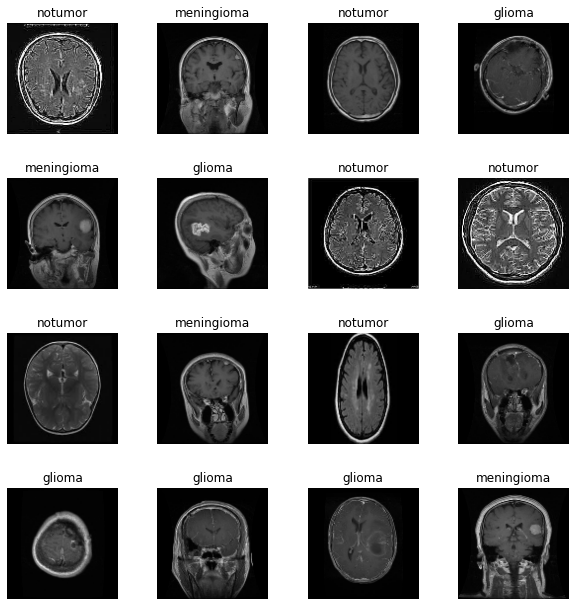

In [8]:
# visualizamos algunos ejemplos
grid_width = 4
grid_height = 4
f, ax = plt.subplots(grid_width, grid_height)
f.set_size_inches(8, 8)

img_idx = 0
for i in range(0, grid_width):
    for j in range(0, grid_height):
        ax[i][j].axis('off')
        ax[i][j].set_title(y_train[img_idx])
        ax[i][j].imshow(X_train[img_idx])
        img_idx += 1

plt.subplots_adjust(left=0, bottom=0, right=1, top=1, wspace=0.2, hspace=0.40)

# guardamos el fichero de imágenes
pyplot.savefig("img_real.png", bbox_inches ="tight")

In [9]:
# definimos el modelo discriminador
def define_discriminator(in_shape=(112,112,3), n_classes=4):
    # etiquetas de entrada
    in_label = Input(shape=(1,))
    # incrustamos las etiquetas
    li = Embedding(n_classes, 50)(in_label)
    # escalamos al tamaño de las imágenes
    n_nodes = in_shape[0] * in_shape[1]
    li = Dense(n_nodes)(li)
    # remodelamos un canal adicional
    li = Reshape((in_shape[0], in_shape[1], 1))(li)
    # entrada de imágenes
    in_image = Input(shape=in_shape)
    # concatenamos imagen y etiqueta
    merge = Concatenate()([in_image, li])
    # reducción por convolución 112x112 -> 56x56
    fe = Conv2D(128, (3,3), strides=(2,2), padding='same', input_shape=in_shape)(merge)
    fe = LeakyReLU(alpha=0.2)(fe)
    # reducción por convolución 56x56 -> 28x28
    fe = Conv2D(128, (3,3), strides=(2,2), padding='same')(fe)
    fe = LeakyReLU(alpha=0.2)(fe)
    # reducción por convolución 28x28 -> 14x14
    fe = Conv2D(128, (3,3), strides=(2,2), padding='same')(fe)
    fe = LeakyReLU(alpha=0.2)(fe)
    # reducción por convolución 14x14 -> 7x7
    fe = Conv2D(128, (3,3), strides=(2,2), padding='same')(fe)
    fe = LeakyReLU(alpha=0.2)(fe)
    # aplanado
    fe = Flatten()(fe)
    # dropout
    fe = Dropout(0.4)(fe)
    # output
    out_layer = Dense(1, activation='sigmoid')(fe)
    # definimos el modelo
    model = Model([in_image, in_label], out_layer)
    # compilamos el modelo
    opt = Adam(learning_rate=0.0002, beta_1=0.5)
    model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])
    return model

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 1)]          0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 1, 50)        200         input_1[0][0]                    
__________________________________________________________________________________________________
dense (Dense)                   (None, 1, 12544)     639744      embedding[0][0]                  
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 112, 112, 3) 0                                            
______________________________________________________________________________________________

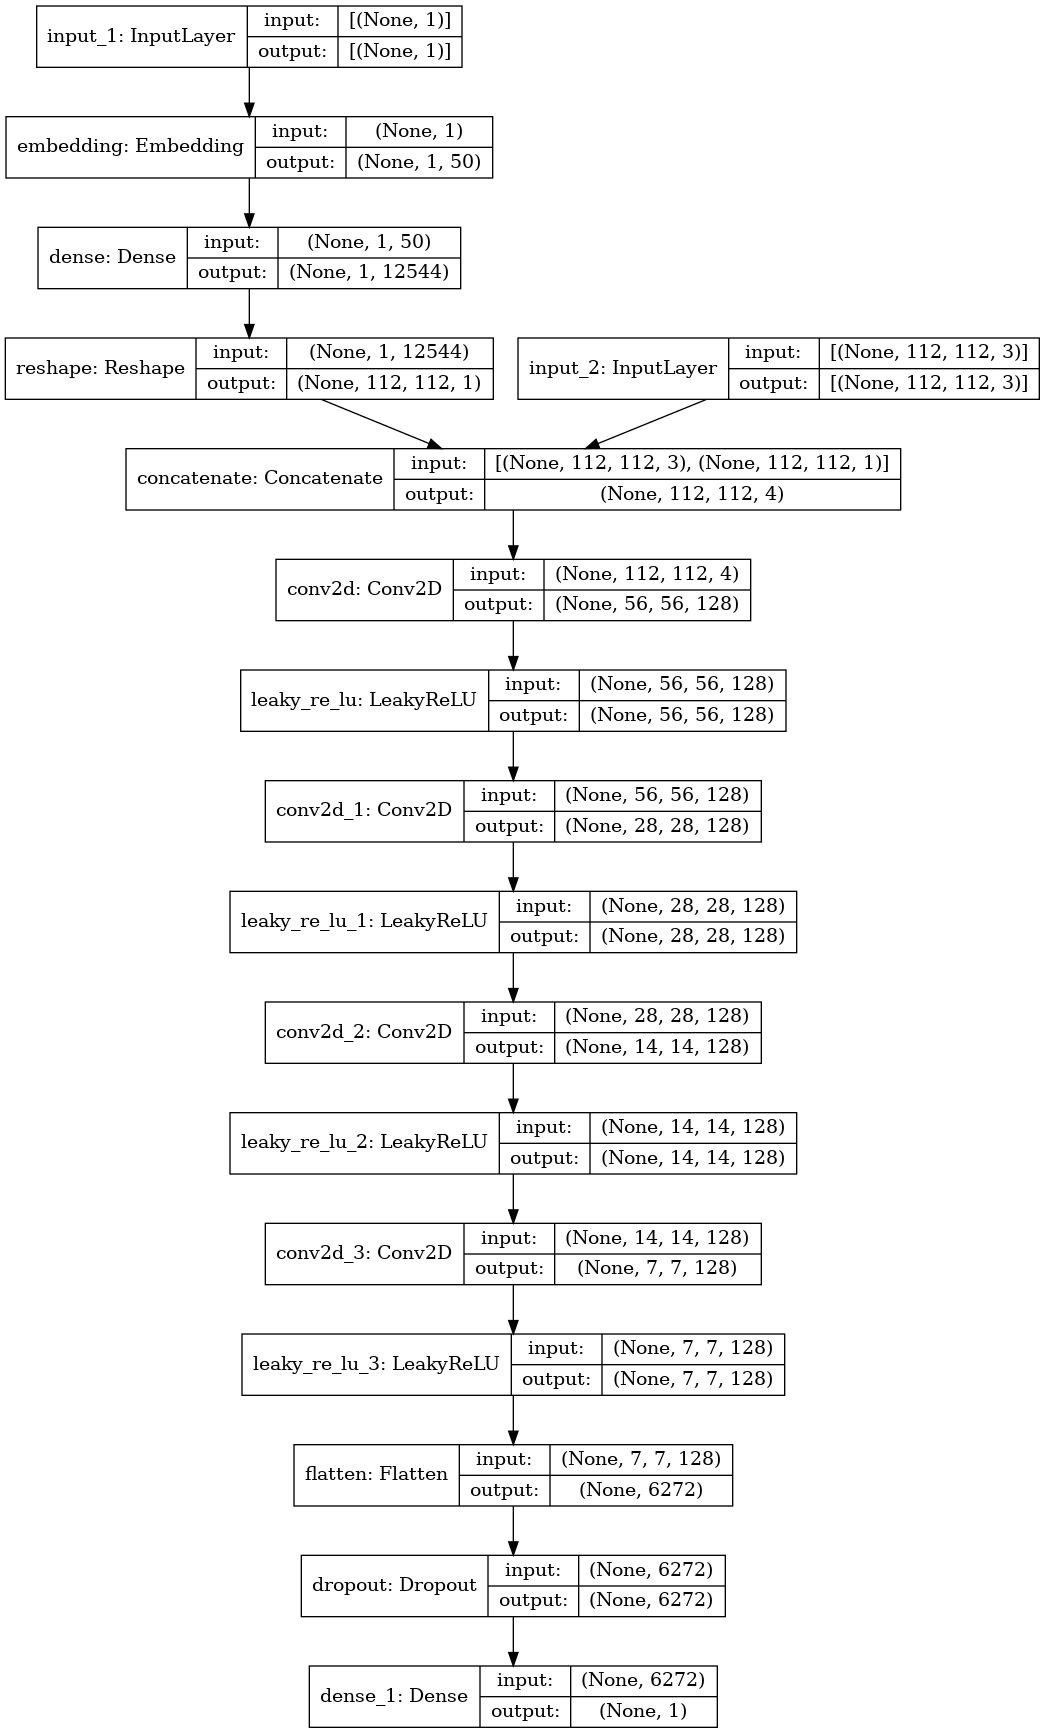

In [10]:
# define model
model = define_discriminator()
# summarize the model
model.summary()
# plot the model
plot_model(model, to_file='discriminator_plot.png', show_shapes=True, show_layer_names=True)

In [11]:
# definimos el modelo generador
# proporcionamos el espacio latente y el número de clases
def define_generator(latent_dim, n_classes=4):
    # etiquetas de entrada
    in_label = Input(shape=(1,))
    # incrustamos las etiquetas
    li = Embedding(n_classes, 50)(in_label)
    # multiplicación
    n_nodes = 7 * 7
    li = Dense(n_nodes)(li)
    # remodelamos un canal adicional
    li = Reshape((7, 7, 1))(li)
    # entrada de imágenes
    in_lat = Input(shape=(latent_dim,))
    # base de la imagen 7x7
    n_nodes = 128 * 7 * 7
    gen = Dense(n_nodes)(in_lat)
    gen = LeakyReLU(alpha=0.2)(gen)
    gen = Reshape((7, 7, 128))(gen)
    # concatenamos imagen y etiqueta
    merge = Concatenate()([gen, li])
    # aumentamos por convolución 7x7 -> 14x14
    gen = Conv2DTranspose(128, (4,4), strides=(2,2), padding='same')(merge)
    gen = LeakyReLU(alpha=0.2)(gen)
    # aumentamos por convolución 14x14 -> 28x28
    gen = Conv2DTranspose(128, (4,4), strides=(2,2), padding='same')(gen)
    gen = LeakyReLU(alpha=0.2)(gen)
    # aumentamos por convolución 28x28 -> 56x56
    gen = Conv2DTranspose(128, (4,4), strides=(2,2), padding='same')(gen)
    gen = LeakyReLU(alpha=0.2)(gen)
    # aumentamos por convolución 56x56 -> 112x112
    gen = Conv2DTranspose(128, (4,4), strides=(2,2), padding='same')(gen)
    gen = LeakyReLU(alpha=0.2)(gen)
    
    # output
    out_layer = Conv2D(3, (7,7), activation='tanh', padding='same')(gen)
    # definimos el modelo (no lo compilamos)
    model = Model([in_lat, in_label], out_layer)
    return model

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            [(None, 100)]        0                                            
__________________________________________________________________________________________________
input_3 (InputLayer)            [(None, 1)]          0                                            
__________________________________________________________________________________________________
dense_3 (Dense)                 (None, 6272)         633472      input_4[0][0]                    
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 1, 50)        200         input_3[0][0]                    
____________________________________________________________________________________________

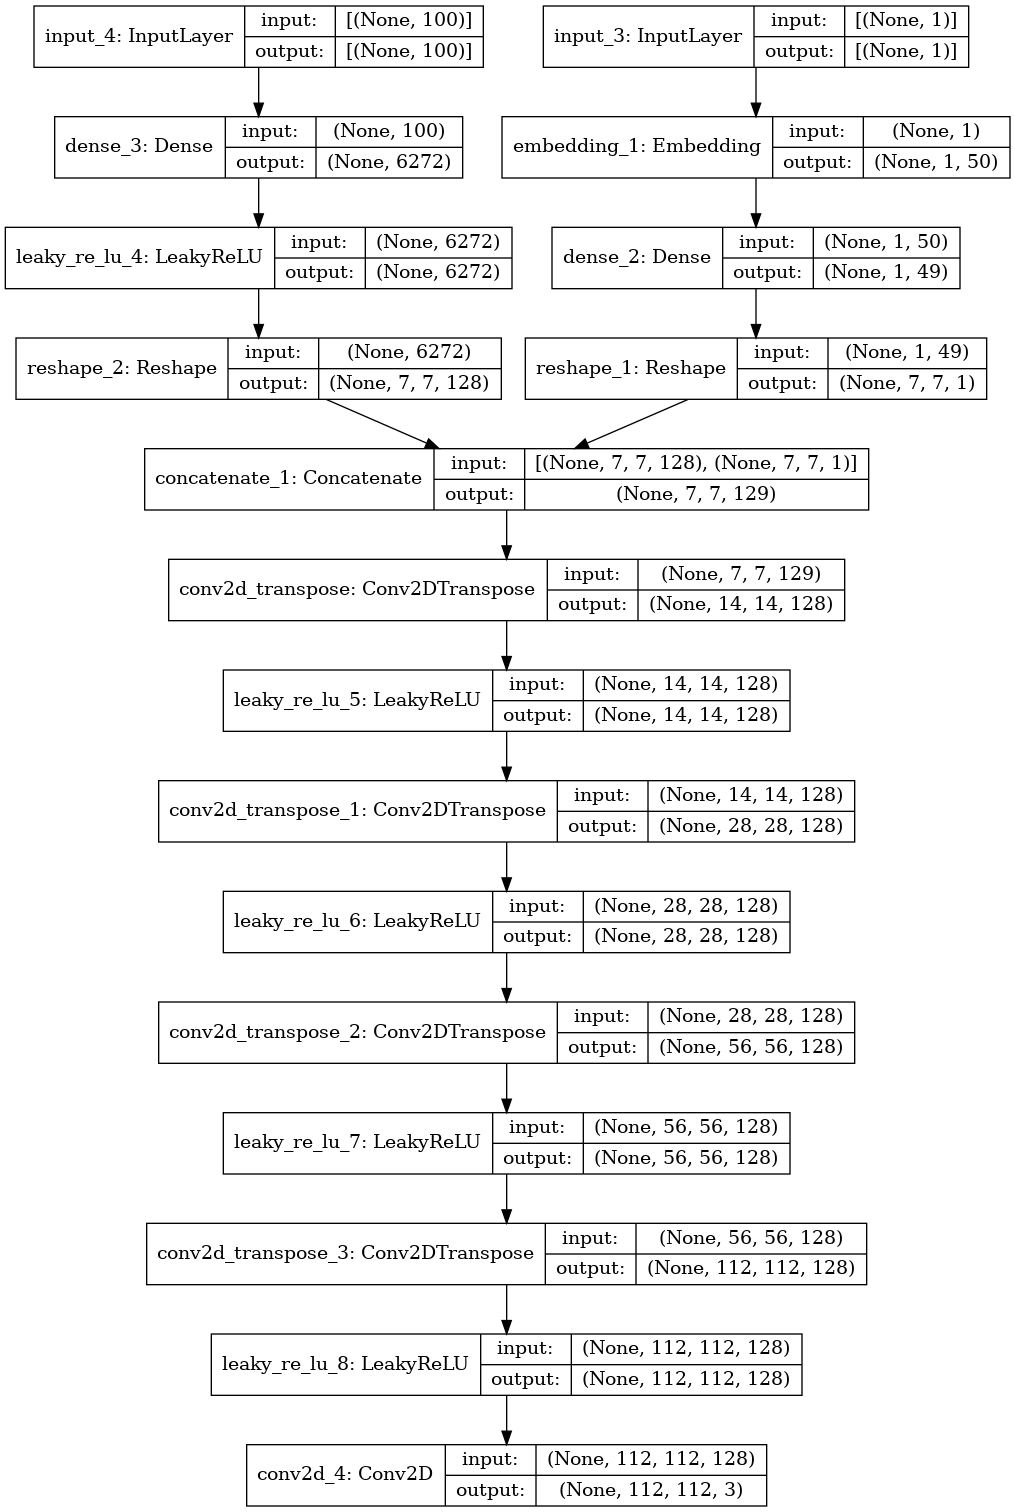

In [12]:
# define model
model = define_generator(latent_dim=100, n_classes=4)
# summarize the model
model.summary()
# plot the model
plot_model(model, to_file='generator_plot.png', show_shapes=True, show_layer_names=True)

In [14]:
# definimos el modelo combinado de generador-discriminador, para actualizar el generador
def define_gan(g_model, d_model, num_d):
    y = []
    # congelamos los modelos discriminadores para que no entrenen
    for n_d in range(num_d):
        d_model[n_d].trainable = False
    # obtenemos la entrada de ruido y etiquetas del modelo generador
    gen_noise, gen_label = g_model.input
    # obtenemos la imagen de salida del modelo generador
    gen_output = g_model.output
    # conectamos la imagen y la etiqueta del generador como entradas del discriminador
    #gan_output = d_model([gen_output, gen_label])
    if num_d==1:
        gan_output = d_model[0]([gen_output, gen_label])
    else:
        for n_d in range(num_d):
            y.append(d_model[n_d]([gen_output, gen_label]))
        # definimos el cálculo (Average, Maximum ó Minimum)
        gan_output = Average()(y)
    # definimos el modelo combinado gan
    model = Model([gen_noise, gen_label], gan_output)
    # compilamos el modelo
    opt = Adam(learning_rate=0.0002, beta_1=0.5)
    model.compile(loss='binary_crossentropy', optimizer=opt)
    return model

In [15]:
# cargamos las imágenes del brain-tumor-mri
def load_real_samples():
    # cargamos los datos de entrenamiento
    #(trainX, trainy), (_, _) = load_data()
    (trainX, trainy) = dataset_bio
    #trainX, trainy = X_train, y_train
    # añadimos un canal -> 3D para la etiqueta de clase
    X = expand_dims(trainX, axis=-1)
    # convertimos de entero a flotante
    X = X.astype('float32')
    # escalamos [0, 255] -> [-1, 1]
    X = (X - 127.5) / 127.5
    return [X, trainy]

In [35]:
# seleccionamos aleatoriamente un grupo de imágenes reales
def generate_real_samples(dataset, n_samples):
    # dividimos en imágenes y etiquetas
    images, labels = dataset
    # selección aleatoria de índices
    ix = randint(0, images.shape[0], n_samples)
    # selección aleatoria de imágenes y etiquetas
    X, labels = images[ix], labels[ix]
    # generamos las etiquetas de clase 1 -> real (0 -> fake)
    y = ones((n_samples, 1))
    return [X, labels], y

# generamos puntos en el espacio latente como entrada para el generador
def generate_latent_points(latent_dim, n_samples, n_classes=4):
    # generamos aleatoriamente puntos
    x_input = randn(latent_dim * n_samples)
    # redimensionamos
    z_input = x_input.reshape(n_samples, latent_dim)
    # generamos las etiquetas
    labels = randint(0, n_classes, n_samples)
    return [z_input, labels]

# utilizamos el generador para crear imágenes falsas
# con etiquetas de clase (0 -> fake)
def generate_fake_samples(g_model, latent_dim, n_samples):
    # generamos puntos en el espacio latente
    z_input, labels_input = generate_latent_points(latent_dim, n_samples)
    # predicción
    images = g_model.predict([z_input, labels_input])
    # generamos las etiquetas de clase 0 -> fake (1 -> real)
    y = zeros((n_samples, 1))
    return [images, labels_input], y


# guardamos un plot con las imágenes generadas (4x4)
def save_plot(examples, epoch, num_d, n=4):
    # creamos el plot
    for i in range(n * n):
        # subplot
        pyplot.subplot(n, n, 1 + i)
        # turn off axis
        pyplot.axis('off')
        # plot
        pyplot.imshow(examples[i, :, :, 0], cmap='gray_r')
    # guardamos el fichero de imágenes
    #filename = 'gen_AVG_plot_e%03d.png' % (epoch+1)
    filename = 'gen_AVG_%dD_plot_e%03d.png' % (num_d, epoch+1)
    pyplot.savefig(filename)
pyplot.close()


# evaluamos el modelo discriminador, generamos imágenes y guardamos el modelo generador
def summarize_performance(epoch, g_model, d_model, num_d, dataset, latent_dim, n_samples=100):
    acc_real = []
    acc_fake = []
    #tot_acc_real = []
    #tot_acc_fake = []
    #tot_epoch = []
    # muestras de imágenes reales
    [X_real, labels_real], y_real = generate_real_samples(dataset, n_samples)
    # muestras de imágenes fake
    [X_fake, labels_fake], y_fake = generate_fake_samples(g_model, latent_dim, n_samples)
    # evaluamos el discriminador con las muestras reales y falsas
    for n_d in range(num_d):
        _, acc_real.append(d_model[n_d].evaluate([X_real, labels_real], y_real, verbose=0))
        _, acc_fake.append(d_model[n_d].evaluate([X_fake, labels_fake], y_fake, verbose=0))
        # rendimiento del discriminador
        print('>Accuracy real_%d: %.0f%%, fake_%d: %.0f%%' % (n_d+1, acc_real[n_d][-1]*100, n_d+1, acc_fake[n_d][-1]*100))
        # guardamos el rendimiento del discriminador
        #tot_acc_real.append(acc_real[n_d]*100)
        #tot_acc_fake.append(acc_fake[n_d]*100)
    #tot_epoch.append(epoch +1)
    # muestras de imágenes fake
    latent_points, labels = generate_latent_points(100, 100)
    # etiquetas
    labels = asarray([x for _ in range(25) for x in range(4)])
    # generamos las imágenes fake
    X  = g_model.predict([latent_points, labels])
    # escalamos [-1, 1] -> [0, 1]
    X = (X + 1) / 2.0
    # salvamos el gráfico
    save_plot(X, epoch, num_d)

    # guardamos el modelo generador
    #filename = 'gen_model_AVG_%03d.h5' % (epoch + 1)
    filename = 'gen_model_AVG_%dD_%03d.h5' % (num_d, epoch + 1)
    g_model.save(filename)


# entrenamos el modelo generador y discriminador
def train(g_model, d_model, num_d, gan_model, dataset, latent_dim, n_epochs, n_batch):
    

    bat_per_epo = int(dataset[0].shape[0] / n_batch)
    half_batch = int(n_batch / 2)
    # recorremos las épocas
    for i in range(n_epochs):
        # recorremos los lotes definidos por época
        for j in range(bat_per_epo):
            # muestras aleatorias de imágenes reales
            [X_real, labels_real], y_real = generate_real_samples(dataset, half_batch)
            # muestras de imágenes fake
            [X_fake, labels_fake], y_fake = generate_fake_samples(g_model, latent_dim, half_batch)
            
            
            
            # actualizamos los pesos del modelo discriminador
            d_loss_real = []
            d_loss_fake = []
            for n_d in range(num_d):
                #d_loss1, _ = d_model.train_on_batch([X_real, labels_real], y_real)
                #d_loss_real.append(d_model[n_d].train_on_batch([X_real, labels_real], y_real))
                #d_loss_fake.append(d_model[n_d].train_on_batch([X_fake, labels_fake], y_fake))
                d_loss_real, _ = d_model[n_d].train_on_batch([X_real, labels_real], y_real)
                d_loss_fake, _ = d_model[n_d].train_on_batch([X_fake, labels_fake], y_fake)
                
                
            # preparamos puntos en el espacio latente como entrada para el modelo generador
            [z_input, labels_input] = generate_latent_points(latent_dim, n_batch)
            # creamos etiquetas falsas para las muestras fake (en lugar de 0)
            y_gan = ones((n_batch, 1))
            # actualizamos el modelo generador mediante el error del discriminador
            g_loss = gan_model.train_on_batch([z_input, labels_input], y_gan)
            
            # pérdidas del lote
            #for n_d in range(num_d):
            #    print('>%d, %d/%d, d_real_%d=%.3f, d_fake%d=%.3f g=%.3f' %
            #    (i+1, j+1, bat_per_epo, n_d+1, d_loss_real[n_d][-1], n_d+1, d_loss_fake[n_d][-1], g_loss))

        # evaluamos el rendimiento del modelo cada 10 épocas
        if (i+1) % 10 == 0:
            summarize_performance(i, g_model, d_model, num_d, dataset, latent_dim)

>Accuracy real_1: 92%, fake_1: 86%
>Accuracy real_2: 93%, fake_2: 95%
>Accuracy real_3: 93%, fake_3: 93%
Tiempo de entrenamiento: 448.9091007709503 segundos


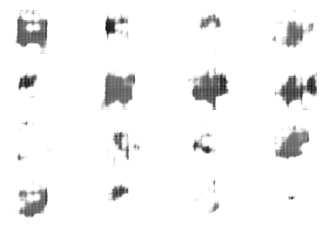

In [34]:
# tamaño imagen
image_shape = (112,112,3)

# épocas
n_epochs = 200
# lote
n_batch = 128
# tamaño del espacio latente (100, 10, 50, 500)
latent_dim = 100
# num discriminators
num_d = 3

# creamos los modelos discriminadores
d_model = []
for n_d in range(num_d):
     d_model.append(define_discriminator())
    
# creamos el modelo generador
g_model = define_generator(latent_dim)
# creamos el modelo combinado
gan_model = define_gan(g_model, d_model, num_d)
# cargamos imágenes reales
dataset = load_real_samples()
# entrenamos la red
inicio = time.time()
train(g_model, d_model, num_d, gan_model, dataset, latent_dim, n_epochs, n_batch)
fin = time.time()
print(f'Tiempo de entrenamiento: {fin - inicio} segundos')

---

## Visualizamos algunas imágenes

In [30]:
# cargamos el modelo

model_guardado = load_model('gen_model_MIN_010.h5')
# generamos espacio latente
latent_points, labels = generate_latent_points(100, 16)
# especificamos etiquetas
labels = asarray([x for _ in range(4) for x in range(4)])

# generamos imágenes
X  = model_guardado.predict([latent_points, labels])

# escalamos
X = (X + 1) / 2.0

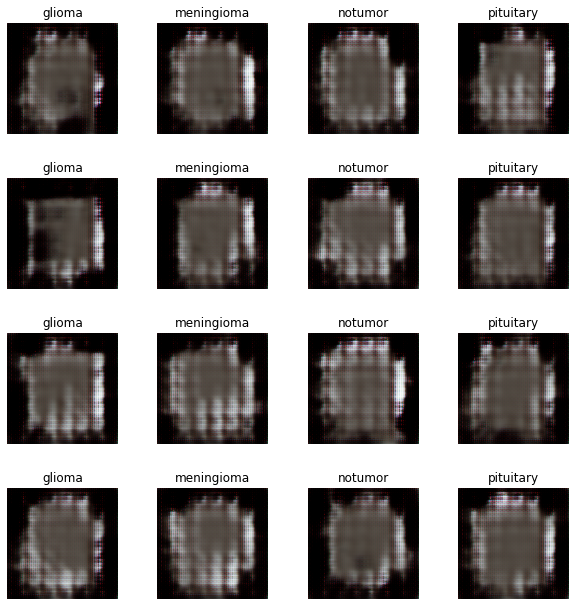

In [31]:
# visualizamos algunos ejemplos
grid_width = 4
grid_height = 4
f, ax = plt.subplots(grid_width, grid_height)
f.set_size_inches(8, 8)

labels = ['glioma', 'meningioma', 'notumor', 'pituitary']
img_idx = 0
for i in range(0, grid_width):    
    for j in range(0, grid_height):
        ax[i][j].axis('off')
        ax[i][j].set_title(labels[j])
        ax[i][j].imshow(X[img_idx])
        img_idx += 1

plt.subplots_adjust(left=0, bottom=0, right=1, top=1, wspace=0.2, hspace=0.40)

# guardamos el fichero de imágenes
pyplot.savefig("img_fake_1D_010.png", bbox_inches ="tight")

## Cálculo del FID y gráfico generado

In [ ]:
# generamos imágenes con modelo generador
# Importamos paquetes necesarios
import numpy
from numpy import cov
from numpy import trace
from numpy import iscomplexobj
from numpy import asarray
from numpy.random import shuffle
from scipy.linalg import sqrtm
from keras.applications.inception_v3 import InceptionV3
from keras.applications.inception_v3 import preprocess_input
from keras.datasets.mnist import load_data
from skimage.transform import resize

# escalamos las imágenes
def scale_images(images, new_shape):
    images_list = list()
    for image in images:
        # redimensionamos con la interpolación del vecino más cercano
        new_image = resize(image, new_shape, 0)
        # guardamos
        images_list.append(new_image)
    return asarray(images_list)

# cálculo del FID
def calculate_fid(model, images1, images2):
    # predicción del modelo InceptionV3
    act1 = model.predict(images1)
    act2 = model.predict(images2)
    # calculamos la media y covarianza
    mu1, sigma1 = act1.mean(axis=0), cov(act1, rowvar=False)
    mu2, sigma2 = act2.mean(axis=0), cov(act2, rowvar=False)
    # calculamos la suma de los cuadrados de la difencia de medias
    ssdiff = numpy.sum((mu1 - mu2)**2.0)
    # calculamos la raiz cuadrada del producto de las covarianzas
    covmean = sqrtm(sigma1.dot(sigma2))
    # comprobamos y corregimos los números imaginarios de la raiz
    if iscomplexobj(covmean):
        covmean = covmean.real
    # calculamos el FID
    fid = ssdiff + trace(sigma1 + sigma2 - 2.0 * covmean)
    return fid

# prepamos el modelo inception v3 (discriminador)
model = InceptionV3(include_top=False, pooling='avg', input_shape=(299,299,3))

# parametros
n_paquetes = 100
n_classes = 4
num_imag = n_paquetes * n_classes

# generamos espacio latente
latent_points, labels = generate_latent_points(100, num_imag, n_classes)

# etiquetas
labels = asarray([x for _ in range(n_paquetes) for x in range(n_classes)])

# cargamos el modelo
fid_epoch = []
epoch = []

# generamos imágenes reales
dataset = load_real_samples()
n_samples = 400
[X_real, labels_real], y_real = generate_real_samples(dataset, n_samples)
X_real = X_real.astype('float32')

#escalamos las imágenes
X_real = scale_images(X_real, (299,299,3))

# preprocesamos imágenes
X_real = preprocess_input(X_real)

# FID para los modelos seleccionados
for i in range(20):
    model_guardado = 'gen_model_1D_%03d.h5' % ((i + 1) * 10)
    model_guardado = load_model(model_guardado)
    
    # generamos imágenes
    X_fake = model_guardado.predict([latent_points, labels])
    X_fake = X_fake.astype('float32')
    # escalamos las imágenes
    X_fake = scale_images(X_fake, (299,299,3))
    print('Scaled', X_real.shape, X_fake.shape)
    # preprocesamos imágenes
    X_fake = preprocess_input(X_fake)
    # calculamos el fid
    fid = calculate_fid(model, X_real, X_fake)
    fid_epoch.append(fid)
    epoch.append((i+1) * 10)
    print('FID: %.3f' % fid)

In [ ]:
# Graficamos
import numpy as np
from matplotlib import pyplot as plt
x = epoch
y = fid_epoch

fig = plt.figure()
fig.clf()
ax = fig.add_subplot(1,1,1)
ax.clear()
ax.plot(x, y,  marker='D')
ax.set_xlabel('epoch')
ax.set_ylabel('fid')
ax.set_title('FID por épocas')
fig.show()

#fig.savefig("FID.png", bbox_inches='tight')
fig.savefig("FID 1D 200E.png")

In [ ]:
fid_epoch

In [13]:
import csv

csvReader = csv.DictReader(open("../input/datosfid/datosFID.csv"))
for row in csvReader:
    print(row)

OrderedDict([('\ufeffEPOCH;FID 3D AVG 200E;FID 3D MIN 200E;FID 3D MAX 200E2;FID 1D 200E3', '10;89'), (None, ['43;92', '89;109', '45;90', '78'])])
OrderedDict([('\ufeffEPOCH;FID 3D AVG 200E;FID 3D MIN 200E;FID 3D MAX 200E2;FID 1D 200E3', '20;26'), (None, ['76;41', '58;109', '46;26', '20'])])
OrderedDict([('\ufeffEPOCH;FID 3D AVG 200E;FID 3D MIN 200E;FID 3D MAX 200E2;FID 1D 200E3', '30;20'), (None, ['65;22', '22;109', '44;19', '93'])])
OrderedDict([('\ufeffEPOCH;FID 3D AVG 200E;FID 3D MIN 200E;FID 3D MAX 200E2;FID 1D 200E3', '40;22'), (None, ['64;16', '29;109', '45;22', '22'])])
OrderedDict([('\ufeffEPOCH;FID 3D AVG 200E;FID 3D MIN 200E;FID 3D MAX 200E2;FID 1D 200E3', '50;16'), (None, ['63;23', '36;109', '45;17', '27'])])
OrderedDict([('\ufeffEPOCH;FID 3D AVG 200E;FID 3D MIN 200E;FID 3D MAX 200E2;FID 1D 200E3', '60;15'), (None, ['46;21', '89;109', '28;16', '48'])])
OrderedDict([('\ufeffEPOCH;FID 3D AVG 200E;FID 3D MIN 200E;FID 3D MAX 200E2;FID 1D 200E3', '70;17'), (None, ['95;22', '31;10

In [71]:
import pandas as pd
import numpy as np

df = pd.read_csv('../input/datosfid2/datosFID.csv', sep=";")

print(df)


    EPOCH  FID 3D AVG 200E  FID 3D MIN 200E  FID 3D MAX 200E2  FID 1D 200E3
0      10            89.43            92.89            109.45         90.78
1      20            26.76            41.58            109.46         26.20
2      30            20.65            22.22            109.44         19.93
3      40            22.64            16.29            109.45         22.22
4      50            16.63            23.36            109.45         17.27
5      60            15.46            21.89            109.28         16.48
6      70            17.95            22.31            103.46         17.77
7      80            13.65            18.47             94.71         16.04
8      90            13.12            16.11             47.40         18.12
9     100            12.77            17.63             28.05         12.22
10    110            13.33            17.54             20.74         12.01
11    120            11.14            14.65             25.18         11.99
12    130   

In [72]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20 entries, 0 to 19
Data columns (total 5 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   EPOCH             20 non-null     int64  
 1   FID 3D AVG 200E   20 non-null     float64
 2   FID 3D MIN 200E   20 non-null     float64
 3   FID 3D MAX 200E2  20 non-null     float64
 4   FID 1D 200E3      20 non-null     float64
dtypes: float64(4), int64(1)
memory usage: 928.0 bytes


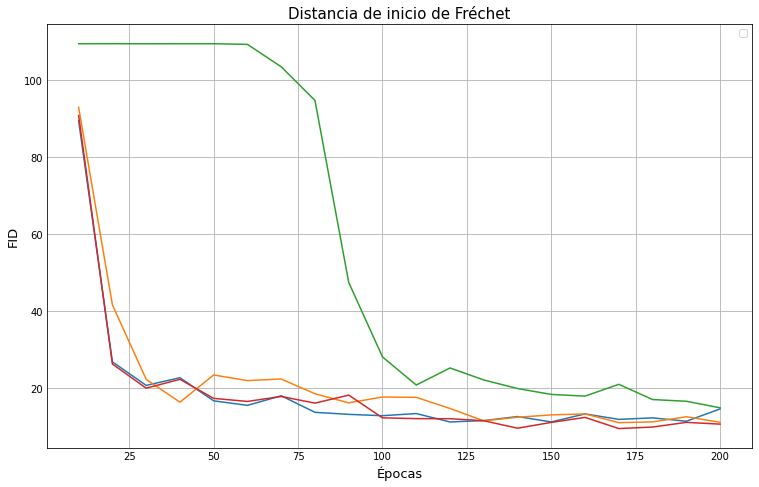

In [98]:
import matplotlib.pyplot as plt
plt_1 = plt.figure(figsize=(10, 6))
plt.plot(df["EPOCH"], df["FID 3D AVG 200E"])
plt.plot(df["EPOCH"], df["FID 3D MIN 200E"])
plt.plot(df["EPOCH"], df["FID 3D MAX 200E2"])
plt.plot(df["EPOCH"], df["FID 1D 200E3"])


plt.title("Distancia de inicio de Fréchet",fontsize=15)
plt.xlabel("Épocas",fontsize=13)
plt.ylabel("FID",fontsize=13)

plt.show()
#fig.savefig("FID.png", bbox_inches='tight')
plt_1.savefig("FID_tot.png", bbox_inches ="tight")

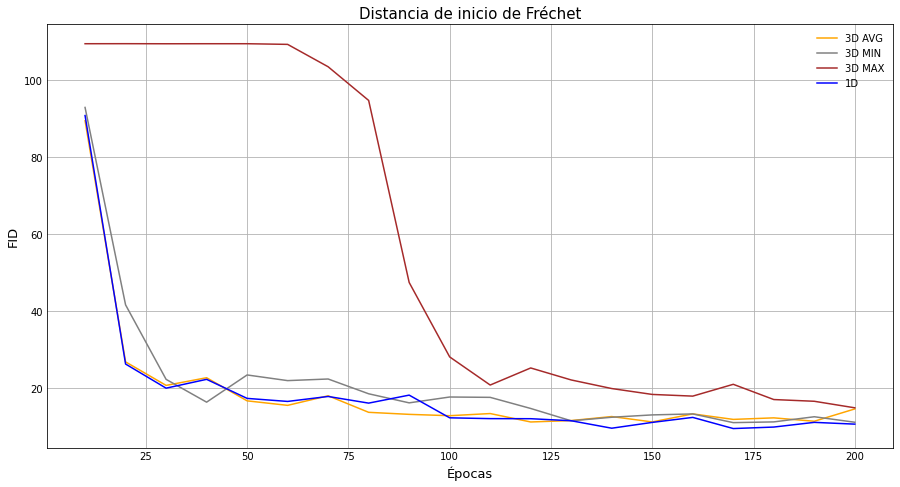

In [121]:
import matplotlib.pyplot as plt
import numpy as np

fig, ax = plt.subplots(figsize=(12, 6))

x = df["EPOCH"]
y1 = df["FID 3D AVG 200E"]
y2 = df["FID 3D MIN 200E"]
y3 = df["FID 3D MAX 200E2"]
y4 = df["FID 1D 200E3"]

ax.plot(x, y1, color="orange", label="3D AVG")
ax.plot(x, y2, color="grey", label="3D MIN")
ax.plot(x, y3, color="brown", label="3D MAX")
ax.plot(x, y4, color="blue", label="1D")
leg = ax.legend(loc="upper right", frameon=False)

plt.title("Distancia de inicio de Fréchet",fontsize=15)
plt.xlabel("Épocas",fontsize=13)
plt.ylabel("FID",fontsize=13)

plt.show()
#fig.savefig("FID.png", bbox_inches='tight')
fig.savefig("FID_tot.png", bbox_inches ="tight")